In [118]:
import pandas as pd
import numpy as np
from malbecs.preprocess import eto as eto_pr
from malbecs.preprocess import wine as wine_pr

<div class="alert alert-block alert-info">
<p><b>CONSEJO</b>: el concepto de dataframe como tabla con filas y columnas existe en muchos lenguajes de programación (pandas de Python, dataframes de R, DataFrames de Spark). Sin embargo, Spark maneja DataFrames que están físicamente distribuidos en las memorias RAM de las máquinas del cluster, lo cual no tiene nada que ver con lo que hace la biblioteca Pandas o R que se ejecutan en una sola máquina. Convertir un DataFrame de Spark en un dataframe de Pandas implica llevar todas las filas al driver, lo cual podría resultar en una excepción Out-of-Memory si el contenido del DataFrame es más grande que la memoria RAM de la máquina en la que se está ejecutando el programa driver. En este caso y en la mayoría de casos, se suele utilizar para mostrar resúmenes o agregados ya calculados previamente, y que sabemos que ocupan poco, con lo que no existe riesgo.</p>

<p>Esta operación también es muy frecuente cuando queremos representar gráficamente el contenido de un DataFrame de Spark. No existen funciones gráficas en Spark, por lo que tenemos que convertirlo en un dataframe de Pandas y utilizar las funciones gráficas de Python habituales (matplotlib, Seaborn o incluso la propia biblioteca Pandas) para mostrar lo que necesitemos.
</p>
</div>

In [129]:
wine_data = pd.read_csv("../../data/raw/UH_2023_TRAIN.txt", sep="|")
wine_data.columns = wine_data.columns.str.lower()
wine_data = wine_pr.replace_zeros_with_na(
        wine_data, cols=['superficie', 'altitud'])
wine_data = wine_pr.fillna_by_group(wine_data, cols=['superficie'], group=[
                                    'id_finca', 'variedad', 'modo'])

In [130]:
# sacamos la productividad
wine_data = wine_data[
    (wine_data['superficie'].notnull()) 
    &
    (wine_data['produccion'].notnull())
].assign(
    prod_he = lambda df: df['produccion']/df['superficie']
)

In [131]:
wine_data.shape

(6729, 12)

In [23]:
eto_data = eto_pr.load_eto_dataset("../../data/raw/DATOS_ETO.TXT")

In [51]:
col_cats = ['Wind',"Temp",'Snow',"Precip","Gust"]


## Precip

In [227]:
percip_data = eto_data[["ID_ESTACION","date",'PrecipAmountLocalDayAvg']].copy()

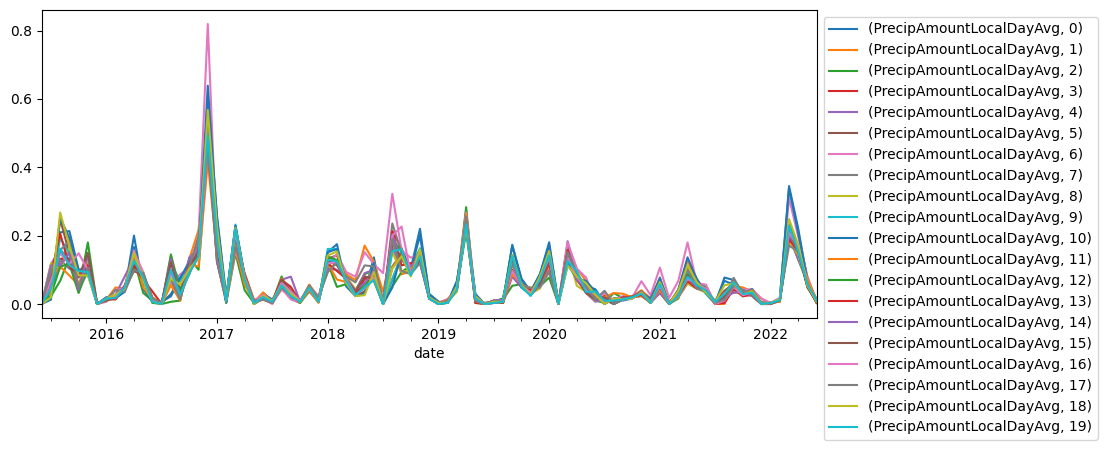

In [84]:
# percip_data.groupby(['ID_ESTACION',percip_data.date.dt.,percip_data.date.dt.month])['PrecipAmountLocalDayAvg'].mean()

percip_data.set_index('date').groupby("ID_ESTACION")[['PrecipAmountLocalDayAvg']].resample("MS").mean().unstack(0).plot(figsize=(10,4)).legend(bbox_to_anchor=(1, 1))

In [96]:
percip_data_pivot = (
    percip_data
    .set_index('date')
    .groupby("ID_ESTACION")
    [['PrecipAmountLocalDayAvg']]
    .resample("MS")
    .mean()
    .rename(columns={"PrecipAmountLocalDayAvg":"PrecipAmountMonthAvg"})
    # .unstack(0)
    # .plot(figsize=(10,4))
    # .legend(bbox_to_anchor=(1, 1))
    .reset_index()
    .assign(
        year = lambda df: df['date'].dt.year,
        month = lambda df: df['date'].dt.month
    )
    [['ID_ESTACION',"month",'year','PrecipAmountMonthAvg']]
    .pivot(
        index=['year','ID_ESTACION'], 
        columns=['month'], 
        values=['PrecipAmountMonthAvg'])
    .reset_index()
    .pipe(eto_pr.flatten_pivot_columns)
    .assign(
        year = lambda df: df['year']%2000
    )
)

In [142]:
percip_data_pivot = eto_pr.fillna_by_group(
        percip_data_pivot,
        cols=percip_data_pivot.columns,
        group=['ID_ESTACION']
    )
# percip_data_pivot.iloc[:,:8]
# wine_data

In [143]:
wine_eto_data = wine_data.merge(
    percip_data_pivot.iloc[:,:8],
    left_on=['campaña','id_estacion'],
    right_on=['year','ID_ESTACION'],
    how='inner'
).drop(columns=['year','ID_ESTACION'])

In [157]:
precip_cols = [c for c in wine_eto_data.columns if "Precip" in c]

In [230]:
prod_he_grouped = (
    wine_eto_data
    .sort_values(["id_zona",'variedad','modo'])
    .set_index([
    'id_zona',
    'variedad',
    'modo',
    ])
    [['prod_he']+precip_cols]
    # .loc[[(441,17,2)],:].corr()
    # .loc[[(38,2)],:].corr()
    # .loc[[(134,59,1)],:].corr()
)
prod_he_grouped

prod_he  PrecipAmountMonthAvg1  \
id_zona variedad modo                                       
7       23       2     2548.879906               0.000000   
                 2     6659.832449               0.148387   
                 2     6934.221180               0.058065   
        59       1     1458.510638               0.084793   
                 1     1769.108349               0.084793   
...                            ...                    ...   
990     59       2     4123.953027               0.225806   
                 2     6655.868375               0.141935   
                 2     4987.105987               0.003226   
                 2     6543.130990               0.154839   
                 2     3504.792332               0.064516   

                       PrecipAmountMonthAvg2  PrecipAmountMonthAvg3  \
id_zona variedad modo                                                 
7       23       2                  0.003571               0.054839   
                 2                  0.000000               0.112903   
                 2                  0.000000               0.032258   
        59       1                  0.029996               0.111521   
                 1                  0.029996               0.111521   
...                                      ...                    ...   
990     59       2                  0.010714               0.222581   
                 2                  0.153571               0.061290   
                 2                  0.003571               0.051613   
                 2                  0.000000               0.112903   
                 2                  0.000000               0.038710   

                       PrecipAmountMonthAvg4  PrecipAmountMonthAvg5  \
id_zona variedad modo                                                 
7       23       2                  0.206667               0.019355   
                 2                  0.076667               0.051613   
                 2                  0.093333               0.064516   
        59       1                  0.110952               0.043318   
                 1                  0.110952               0.043318   
...                                      ...                    ...   
990     59       2                  0.073333               0.000000   
                 2                  0.023333               0.025806   
                 2                  0.223333               0.022581   
                 2                  0.080000               0.061290   
                 2                  0.113333               0.064516   

                       PrecipAmountMonthAvg6  
id_zona variedad modo                         
7       23       2                  0.000000  
                 2                  0.020000  
                 2                  0.030000  
        59       1                  0.000000  
                 1                  0.000000  
...                                      ...  
990     59       2                  0.023333  
                 2                  0.093333  
                 2                  0.000000  
                 2                  0.026667  
                 2                  0.033333  

[6093 rows x 7 columns]

['PrecipAmountMonthAvg1',
 'PrecipAmountMonthAvg2',
 'PrecipAmountMonthAvg3',
 'PrecipAmountMonthAvg4',
 'PrecipAmountMonthAvg5',
 'PrecipAmountMonthAvg6']

<Figure size 640x480 with 0 Axes>

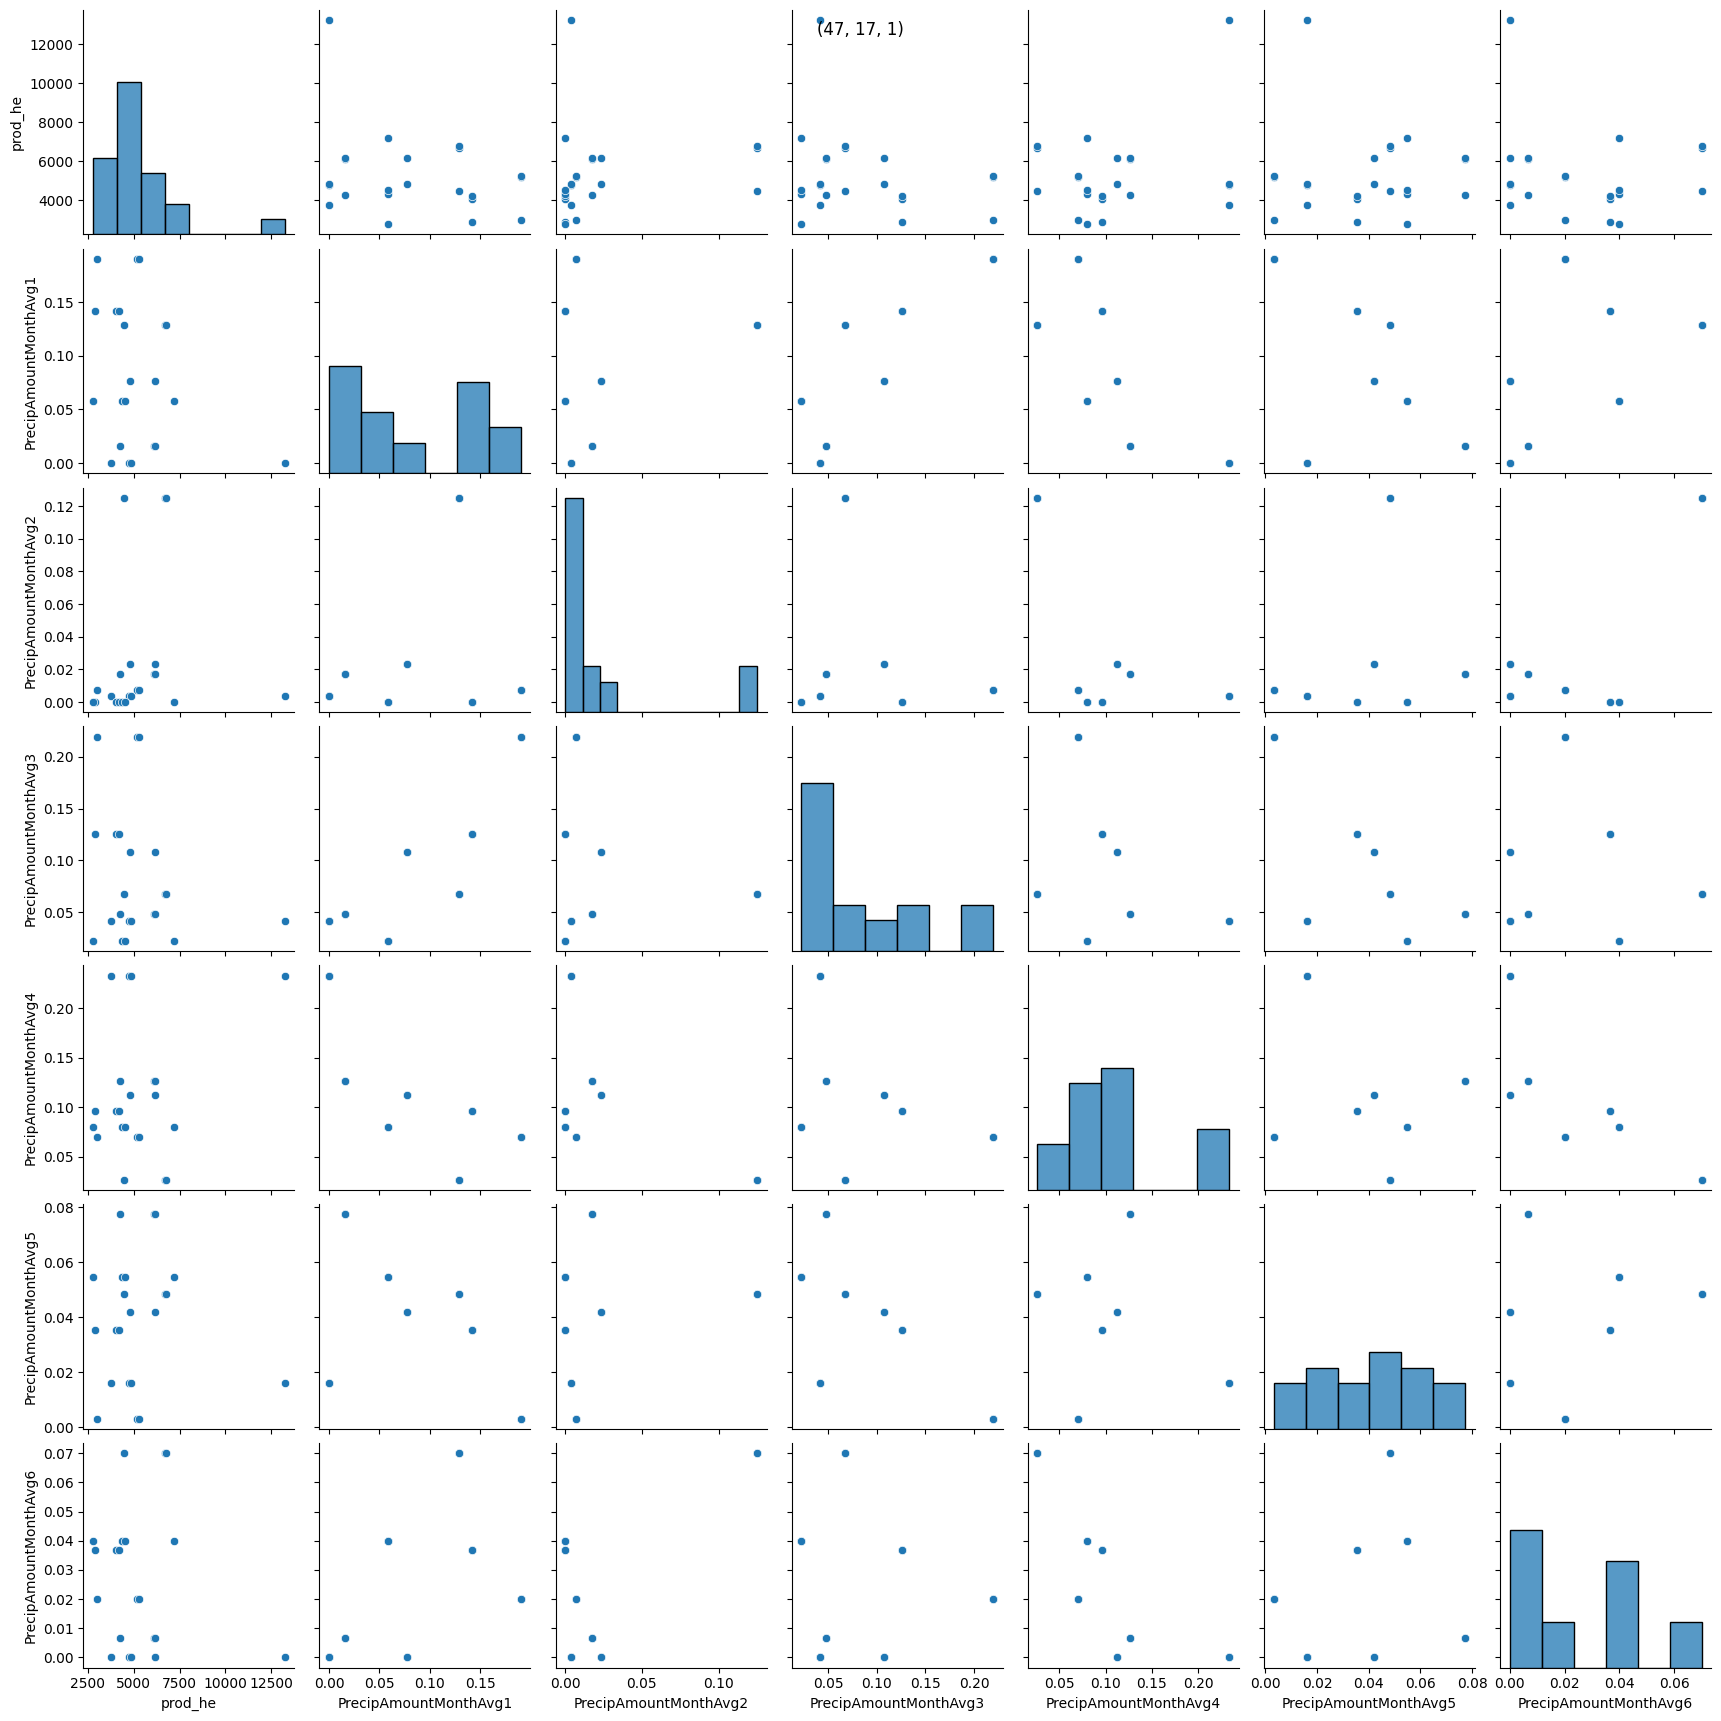

In [262]:
import seaborn as sns
import matplotlib.pyplot as plt

for idx in prod_he_grouped.index.unique():
    n_obs = prod_he_grouped.loc[idx,:].shape[0]
    if n_obs > 20:
        # for c in prod_he_grouped.columns.to_list()[1:]:
        plt.figure()
        g = sns.pairplot(prod_he_grouped.loc[idx,:])
        g.fig.suptitle(idx)
        plt.show()
        break


In [226]:
wine_eto_data[wine_eto_data['variedad']==38]

,campaña,id_finca,id_zona,id_estacion,altitud,variedad,modo,tipo,color,superficie,produccion,prod_he,PrecipAmountMonthAvg1,PrecipAmountMonthAvg2,PrecipAmountMonthAvg3,PrecipAmountMonthAvg4,PrecipAmountMonthAvg5,PrecipAmountMonthAvg6
3789,19,97437,74,19,550-570,38,2,0,0,3.53,14340.0,4062.322946,0.000000,0.003571,0.041935,0.233333,0.016129,0.000000
4772,20,97437,74,19,550-570,38,2,0,0,3.53,18370.0,5203.966006,0.141935,0.000000,0.125806,0.096667,0.035484,0.036667
4791,20,91845,47,19,520-540,38,2,0,0,0.69,5360.0,7768.115942,0.141935,0.000000,0.125806,0.096667,0.035484,0.036667
5994,21,97437,74,19,550-570,38,2,0,0,3.53,20960.0,5937.677054,0.058065,0.000000,0.022581,0.080000,0.054839,0.040000


In [205]:
# wine_eto_data.groupby(['id_zona'])['variedad'].value_counts().sort_values(ascending=False)
# wine_eto_data['variedad'].value_counts().sort_values(ascending=False)

In [222]:
(
    wine_eto_data
    .sort_values(["id_zona",'variedad','modo'])
    .groupby([
        # 'id_zona',
        'variedad',
        # 'modo',
    ])
    [['prod_he','PrecipAmountMonthAvg4']]
    .corr()
    .unstack(-1).iloc[:,[1]]
    .abs()
    .droplevel(0, axis=1)
    .sort_values('PrecipAmountMonthAvg4',ascending=False)
    # .loc[[(134,59,2)],:]
)
# .unstack(-1).iloc[:,[1]].hist()

,PrecipAmountMonthAvg4
variedad,
48,1.000000
38,0.697935
62,0.314470
9,0.215227
10,0.166627
84,0.163663
8,0.158907
65,0.158859
55,0.128325


In [291]:
# percip_data.set_index('date').groupby("ID_ESTACION")[['PrecipAmountLocalDayAvg']].resample("MS").mean().unstack(0).plot(figsize=(10,4)).legend(bbox_to_anchor=(1, 1))

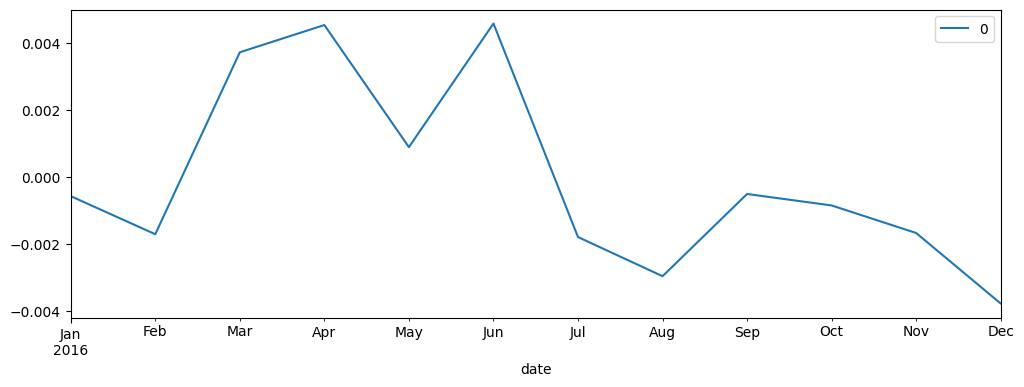

In [304]:
from statsmodels.tsa.seasonal import seasonal_decompose

# res = seasonal_decompose(eto_data.set_index(["ID_ESTACION","date"])['PrecipAmountLocalDayAvg'], period=365)
res = seasonal_decompose(percip_data.set_index('date').groupby("ID_ESTACION")[['PrecipAmountLocalDayAvg']].resample("MS").mean(), period=12)

# res.seasonal.unstack(0).iloc[:365,0].plot()

# res.resid.unstack(0).iloc[:365,0].plot()
# res.resid.unstack(0).plot(figsize=(12,4)).legend(bbox_to_anchor=(1, 1))
# res.seasonal.unstack(0).iloc[7:19,[1]].plot(kind="bar",figsize=(12,4)).legend(bbox_to_anchor=(1, 1))
res.seasonal.unstack(0).iloc[7:19,[0]].plot(figsize=(12,4)).legend(bbox_to_anchor=(1, 1))
# res.resid.unstack(0).iloc[:,:].plot(figsize=(12,4)).legend(bbox_to_anchor=(1, 1))


# res.plot()

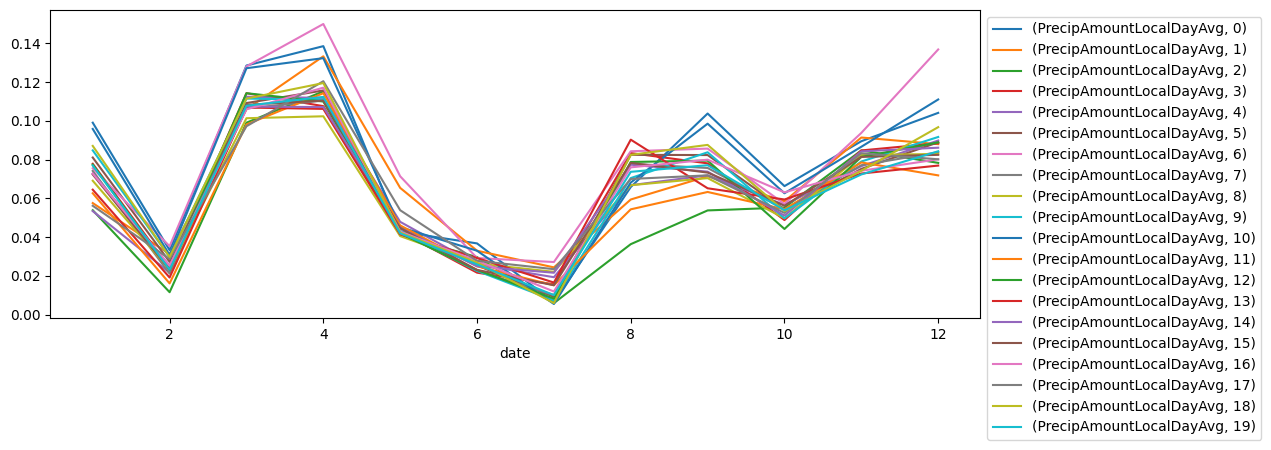

In [302]:
percip_data
percip_data.set_index('date').groupby("ID_ESTACION")[['PrecipAmountLocalDayAvg']].resample("MS").mean()

percip_data.groupby(
    ["ID_ESTACION",percip_data.date.dt.month]
)[['PrecipAmountLocalDayAvg']].mean().unstack(0).plot(figsize=(12,4)).legend(bbox_to_anchor=(1, 1))

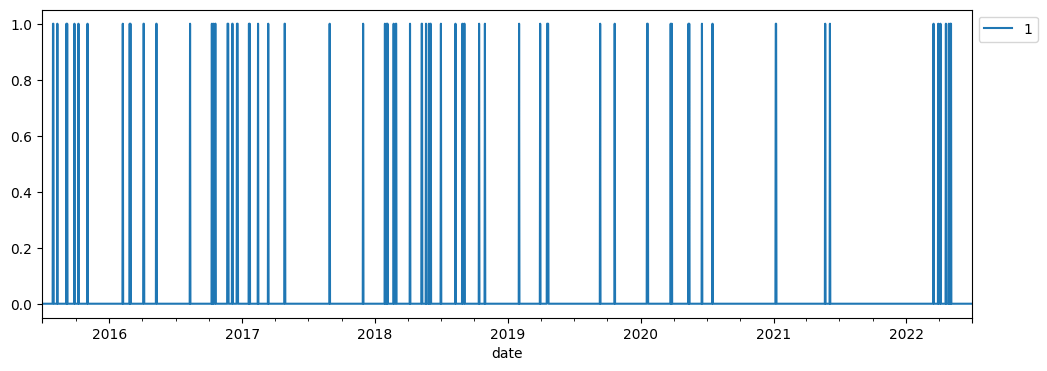

In [336]:
precip_month = (
    percip_data
    .groupby(
    ["ID_ESTACION",percip_data.date.dt.month]
    )
    .agg(
        PrecipAmountMonthAvg = ('PrecipAmountLocalDayAvg','mean'),
        PrecipAmountMonthStd = ('PrecipAmountLocalDayAvg','std'),
    )
    .reset_index()
    .rename(columns={
        "date":"month",
    })
)
percip_data['month'] = percip_data['date'].dt.month

(percip_data
    .merge(
        precip_month,
        left_on=['ID_ESTACION','month'],
        right_on=['ID_ESTACION','month']
    )
    .assign(
        PrecipDayMonthDiff = lambda df: df['PrecipAmountLocalDayAvg'] - df['PrecipAmountMonthAvg']
    )
    .assign(
        PrecipBelowAvg = lambda df: (df['PrecipDayMonthDiff'] < 0).astype(int),
        PrecipAvobeAvg = lambda df: (df['PrecipDayMonthDiff'] > 0).astype(int),
        PrecipAvobe2Std = lambda df: (df['PrecipDayMonthDiff'] > df['PrecipAmountMonthStd']*2).astype(int),
        PrecipAvobe3Std = lambda df: (df['PrecipDayMonthDiff'] > df['PrecipAmountMonthStd']*3).astype(int),
    )
    .set_index(["ID_ESTACION","date"])
    .unstack(0)
    ['PrecipAvobe2Std']
    [[1]]
    .plot(figsize=(12,4)).legend(bbox_to_anchor=(1, 1))
)

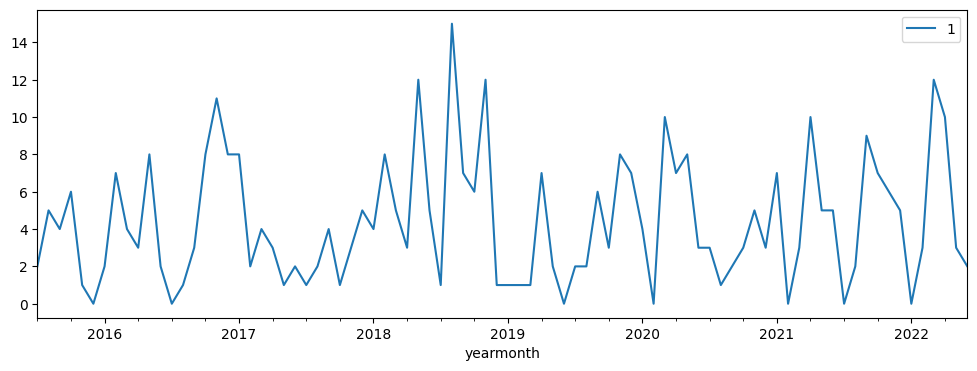

In [366]:
(percip_data
    .assign(
        month = percip_data['date'].dt.month,
        year = percip_data['date'].dt.year,
    )
    .merge(
        precip_month,
        left_on=['ID_ESTACION','month'],
        right_on=['ID_ESTACION','month']
    )
    .assign(
        PrecipDayMonthDiff = lambda df: df['PrecipAmountLocalDayAvg'] - df['PrecipAmountMonthAvg']
    )
    .assign(
        PrecipBelowAvg = lambda df: (df['PrecipDayMonthDiff'] < 0).astype(int),
        PrecipAvobeAvg = lambda df: (df['PrecipDayMonthDiff'] > 0).astype(int),
        PrecipAvobe2Std = lambda df: (df['PrecipDayMonthDiff'] > df['PrecipAmountMonthStd']*2).astype(int),
        PrecipAvobe3Std = lambda df: (df['PrecipDayMonthDiff'] > df['PrecipAmountMonthStd']*3).astype(int),
    )
    # .set_index(["ID_ESTACION","date"])
    .groupby(["ID_ESTACION","year",'month'])
    [['PrecipBelowAvg','PrecipAvobeAvg','PrecipAvobe2Std','PrecipAvobe3Std']]
    .sum()
    .reset_index()
    .assign(
        yearmonth = lambda df: pd.to_datetime(df['year'].astype(str)+"-"+df['month'].astype(str))
    )
    .set_index(["ID_ESTACION","yearmonth"])
    .unstack(0)
    ['PrecipAvobeAvg']
    .iloc[1:,[1]]
    .plot(figsize=(12,4)).legend(bbox_to_anchor=(1, 1))

)

## Temp

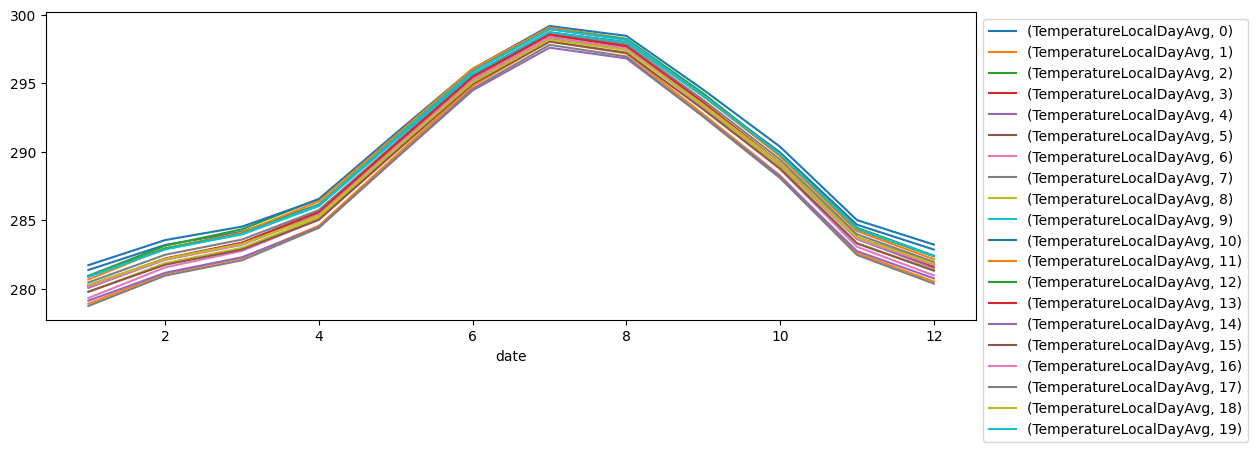

In [370]:
temp_data = eto_data[["ID_ESTACION","date",'TemperatureLocalDayAvg']].copy()


temp_data.set_index('date').groupby("ID_ESTACION")[['TemperatureLocalDayAvg']].resample("MS").mean()

temp_data.groupby(
    ["ID_ESTACION",percip_data.date.dt.month]
)[['TemperatureLocalDayAvg']].mean().unstack(0).plot(figsize=(12,4)).legend(bbox_to_anchor=(1, 1))

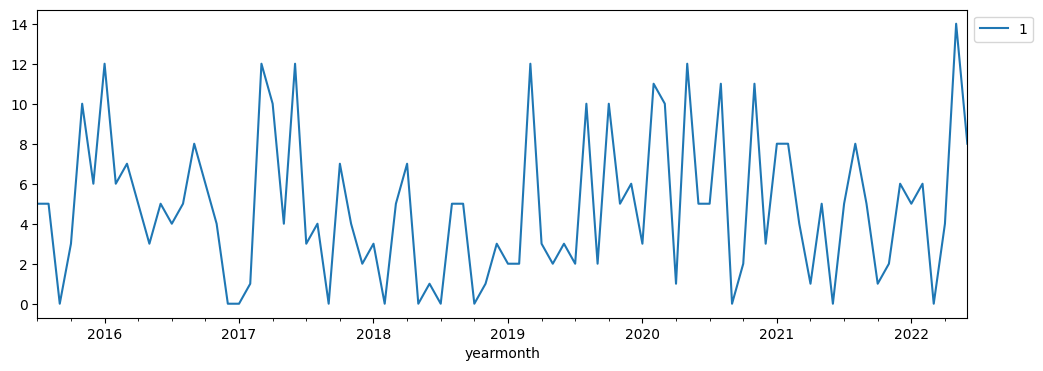

In [382]:
temp_month = (
    temp_data
    .groupby(
    ["ID_ESTACION",temp_data.date.dt.month]
    )
    .agg(
        TempDayMonthAvg = ('TemperatureLocalDayAvg','mean'),
        TempDayMonthStd = ('TemperatureLocalDayAvg','std'),
    )
    .reset_index()
    .rename(columns={
        "date":"month",
    })
)
temp_data['month'] = temp_data['date'].dt.month

(temp_data
    .assign(
        month = temp_data['date'].dt.month,
        year = temp_data['date'].dt.year,
    )
    .merge(
        temp_month,
        left_on=['ID_ESTACION','month'],
        right_on=['ID_ESTACION','month']
    )
    .assign(
        TempDayMonthDiff = lambda df: df['TemperatureLocalDayAvg'] - df['TempDayMonthAvg']
    )
    .assign(
        TempAvobe1Std = lambda df: (df['TempDayMonthDiff'] > df['TempDayMonthStd']).astype(int),
        TempAvobe2Std = lambda df: (df['TempDayMonthDiff'] > df['TempDayMonthStd']*2).astype(int),
        TempBelow1Std = lambda df: (df['TempDayMonthDiff'] < -df['TempDayMonthStd']).astype(int),
        TempBelow2Std = lambda df: (df['TempDayMonthDiff'] < -df['TempDayMonthStd']*2).astype(int),
    )

    
    # .set_index(["ID_ESTACION","date"])
    # .unstack(0)
    # ['TempBelow2Std']
    # [[1]]
    # .plot(figsize=(12,4)).legend(bbox_to_anchor=(1, 1))

    .groupby(["ID_ESTACION","year",'month'])
    [['TempBelow1Std','TempAvobe1Std','TempAvobe2Std','TempBelow2Std']]
    .sum()
    .reset_index()
    .assign(
        yearmonth = lambda df: pd.to_datetime(df['year'].astype(str)+"-"+df['month'].astype(str))
    )
    .set_index(["ID_ESTACION","yearmonth"])
    .unstack(0)
    ['TempAvobe1Std']
    .iloc[1:,[1]]
    .plot(figsize=(12,4)).legend(bbox_to_anchor=(1, 1))

)

## Snow

In [420]:
def get_mean_and_std_by_month(eto_data, column):
    return (
        eto_data
        [['ID_ESTACION','date',column]]
        .groupby(
        ["ID_ESTACION",eto_data.date.dt.month]
        )
        .agg(
            mean = (column,'mean'),
            std = (column,'std'),
        )
        .reset_index()
        .rename(columns={
            "date":"month",
        })
    )


def get_days_over_and_under_mean(eto_data, column, out_column_name, over=True, under=True):

    def rename(df):
        return df.rename(columns={c:f"{out_column_name}{c}" for c in df.columns})
    
    def select(df):
        overcols = [c for c in df.columns if 'Over' in c] if over else []
        undercols = [c for c in df.columns if 'Uneder' in c] if under else []
        return df[overcols + undercols]

    month_data = get_mean_and_std_by_month(eto_data, column)

    return (eto_data
     [['ID_ESTACION','date',column]]
        .assign(
            month = eto_data['date'].dt.month,
            year = eto_data['date'].dt.year,
        )
        .merge(
            month_data,
            left_on=['ID_ESTACION','month'],
            right_on=['ID_ESTACION','month']
        )
        .assign(
            Diff = lambda df: df[column] - df['mean']
        )
        .assign(
            Over1Std = lambda df: (df['Diff'] > df["std"]).astype(int),
            Over2Std = lambda df: (df['Diff'] > df["std"]*2).astype(int),
            Under1Std = lambda df: (df['Diff']< -df["std"]).astype(int),
            Under2Std = lambda df: (df['Diff']< -df["std"]*2).astype(int),
        )
        .groupby(["ID_ESTACION","year",'month'])
        [['Under1Std','Over1Std','Over2Std','Under2Std']]
        .sum()
        .pipe(select)
        .pipe(rename)
    )


d = get_days_over_and_under_mean(
    eto_data, 
    column="TemperatureLocalDayAvg", 
    out_column_name="Temp",
    over=True,
    under=True
).join(
    get_days_over_and_under_mean(
    eto_data, 
    column="PrecipAmountLocalDayAvg", 
    out_column_name="Precip",
    under=False
    )
).join(
    get_days_over_and_under_mean(
        eto_data, 
        column="SnowAmountLocalDayAvg", 
        out_column_name="Snow",
        under=False
    )
).join(
    get_days_over_and_under_mean(
        eto_data, 
        column="WindSpeedLocalDayAvg", 
        out_column_name="Wind",
        under=False
    )
).join(
    get_days_over_and_under_mean(
    eto_data, 
    column="GustLocalDayAvg", 
    out_column_name="Gust",
    under=False
    )
)


In [425]:

d =eto_pr.filter_relevant_months(d.reset_index())
eto_pr.pivot_monthly_data(d)
    # index = ['year', 'ID_ESTACION']
    # columns = ['month']
    # values = eto_month.drop(columns=index+columns).columns.tolist()
    # eto_pivot = eto_month.pivot(
    #     index=index, columns=columns, values=values).reset_index()

,year,ID_ESTACION,TempOver1StdMonth1,TempOver1StdMonth2,TempOver1StdMonth3,TempOver1StdMonth4,TempOver1StdMonth5,TempOver1StdMonth6,TempOver2StdMonth1,TempOver2StdMonth2,...,GustOver1StdMonth3,GustOver1StdMonth4,GustOver1StdMonth5,GustOver1StdMonth6,GustOver2StdMonth1,GustOver2StdMonth2,GustOver2StdMonth3,GustOver2StdMonth4,GustOver2StdMonth5,GustOver2StdMonth6
0,2015,0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0
1,2015,1,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0
2,2015,2,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0
3,2015,3,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0
4,2015,4,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,2022,15,5.0,5.0,0.0,6.0,15.0,9.0,0.0,0.0,...,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
156,2022,16,4.0,4.0,0.0,6.0,12.0,6.0,0.0,0.0,...,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
157,2022,17,6.0,6.0,0.0,4.0,14.0,8.0,0.0,0.0,...,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
158,2022,18,5.0,5.0,0.0,6.0,13.0,7.0,0.0,0.0,...,1.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
